In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate 
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt 
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
from PIL import Image
import matplotlib.pyplot as plt
import scipy.misc



Using TensorFlow backend.


In [2]:
PillModel = PillRecoModel(input_shape=(3,96,96))
print("Total Params:", PillModel.count_params())

Total Params: 3743280


In [3]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
     Implementation of the triplet loss as defined by formula (3)
Arguments:
y true -- true labels, required when you define a loss in Keras, you don't need it in
this function.
y pred -- python list containing three objects:
             anchor -- the encodings for the anchor images, of shape (None, 128)
             positive -- the encodings for the positive images, of shape (None, 128)
             negative -- the encodings for the negative images, of shape (None, 128)
     Returns:
     loss -- real number, value of the loss
     """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dis=tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    neg_dis=tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    
    basic_loss=tf.subtract(pos_dis,neg_dis)+alpha
    
    loss=tf.reduce_sum(tf.maximum(basic_loss,0))
    
    return loss
    

In [4]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
    tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
    tf.random_normal([3, 128], mean=3, stddev=4, seed = 1)) 
    loss = triplet_loss(y_true, y_pred)
    print("loss = " + str(loss.eval()))

loss = 528.1427


In [4]:
PillModel.compile(optimizer='adam',loss=triplet_loss,metrics=['accuracy'])
load_weights_from_FaceNet(PillModel)
# FRmodel.fit(epochs=1,batch_size=2)

In [5]:
def read_and_resize(image_path):
    img1=Image.open(image_path)
    img1=scipy.misc.imresize(img1, (2000, 2000))
    img=img1[:,200:2201]
    img=cv2.resize(img,(96,96),interpolation=cv2.INTER_NEAREST)

    plt.imshow(img)
    
    return img


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


96

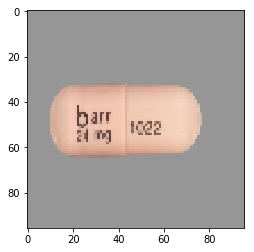

In [6]:
pill_classes=[]
database={}

def creating_database():
    for i in os.listdir('images/'):
        if not os.path.isfile(os.path.join('images/',i)):
            count=0
            for pill_name in os.listdir(os.path.join('images/',i)):
                pill_classes.append(str(i+str(count)))
                img_path=os.path.join('images/',i)
                img_path=os.path.join(img_path,pill_name)
                img=read_and_resize(img_path)
                database[str(i+str(count))]=img_to_encoding(img,PillModel)
                count+=1;
creating_database()
len(database)

In [7]:
def verify_pill(image_path, identity, database, model):
    if type(image_path)==str:
        img1 = cv2.imread(image_path, 1)
    else:
        img1=image_path
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    encoding = model.predict_on_batch(x_train)
    
    dist=np.linalg.norm(encoding-database[identity])
       
    return dist

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0 23
Alprazolam_1_MG_Oral_T1
23 46
12_HR_Acetazolamide_500_MG_Extended_Release_Oral_Ca0
46 69
12_HR_Acetazolamide_500_MG_Extended_Release_Oral_Ca23
69 92
24_HR_Cyclobenzaprine_hydrochloride_15_MG_Extended_Release_Oral_Capsule_A22


'Alprazolam_1_MG_Oral_T1'

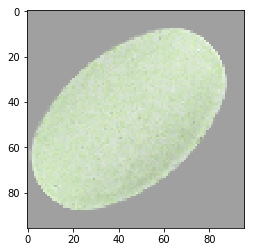

In [50]:
file_rec='output0.jpg'
img_rec=os.path.join('pill_reciever_splited/',file_rec)


def recongize(img_rec):
    scores={}
    score_list=[]
    score_avg={}
    img_to_test=read_and_resize(img_rec)
    for i in pill_classes:
        scores[i]=verify_pill(img_to_test,i,database,PillModel)
        score_list.append(verify_pill(img_to_test,i,database,PillModel))
#         print("{0} scores{1}".format(i,scores[i]))
    k=0
    for i in range(len(database))[::23]:
        if i!=0:
            print(k,i)
            tmp_list=score_list[k:i]
            avg=sum(tmp_list)/len(tmp_list)
            print(list(scores.keys())[k+1])
            score_avg[list(scores.keys())[k+1]]=avg
            k=i
    reco_pill=min(score_avg, key=lambda k: score_avg[k])
    return reco_pill
recongize(img_rec)

In [ ]:
min(score.items())[0]

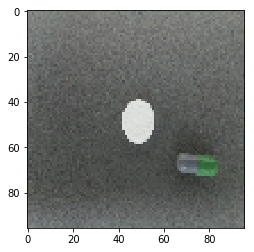

In [58]:
img=read_and_resize('pill_reciever_splited/image4.jpg')

In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(

    zca_whitening=False,

    rotation_range=40,

    width_shift_range=0.0,

    height_shift_range=0.0,

    shear_range=0.0,

    zoom_range=0.0,

    horizontal_flip=True,

    fill_mode='nearest')



In [56]:
img = cv2.imread("images/12_HR_Acetazolamide_500_MG_Extended_Release_Oral_Ca/12_HR_Acetazolamide_500_MG_Extended_Release_Oral_Ca_1.jpg")
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.reshape((1,) + img.shape)
print(img.dtype)
#             plt.imshow(img)
img = img.astype(np.uint8)
for i in os.listdir('images/'):
    if not os.path.isfile(os.path.join('images/',i)):
        for p in os.listdir(os.path.join('images/',i)):
            path=os.path.join('images/',i)
        
            ##mkdir
            if not os.path.isdir(os.path.join(path,'data_aug')):
                os.mkdir(os.path.join(path,'data_aug'))
            if p!='data_aug':
                pill_name=p[0:len(p)-5]
#                 print(pil)
                file=os.path.join(path,p)
                img=cv2.imread(file)
                img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.reshape((1,) + img.shape)
                count=0;
                print("count:"+str(count+3))
                for batch in datagen.flow(img, batch_size=10,save_to_dir=path, save_prefix=pill_name, save_format='jpg'):
#                     plt.subplot(5,4,1 + i)
#                     plt.axis("off")
#                     augImage = batch[0]
#                     augImage = augImage.astype('float32')
#                     augImage /= 255
#                     plt.imshow(augImage)
                    count+=1
                    if count > 10:
                        break
    #             os.remove(os.path.join(dir,folder,file))

(1600, 2400, 3)
uint8
count:3
count:3
count:3
count:3
count:3
count:3
count:3
count:3


In [31]:
for i in os.listdir('images/'):
    if not os.path.isfile(os.path.join('images/',i)):
        for p in os.listdir(os.path.join('images/',i)):
            path=os.path.join('images/',i)
            pill_name=p[0:len(p)-5]
            print(pill_name)

Alprazolam_1_MG_Oral_T_1
Alprazolam_1_MG_Oral_T_2
12_HR_Acetazolamide_500_MG_Extended_Release_Oral_Ca_2
data
12_HR_Acetazolamide_500_MG_Extended_Release_Oral_Ca_1
.DS_S
24_HR_Cyclobenzaprine_hydrochloride_15_MG_Extended_Release_Oral_Capsule_A_2
24_HR_Cyclobenzaprine_hydrochloride_15_MG_Extended_Release_Oral_Capsule_A_1
24_HR_galantamine_hydrobromide_24_MG_Extended_Release_Oral_Ca_2
24_HR_galantamine_hydrobromide_24_MG_Extended_Release_Oral_Ca_1


In [33]:
str(0+4)

'4'

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


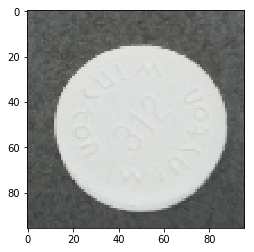

In [62]:
img_path="pill_reciever_splited/output1.jpg"
img=read_and_resize(img_path)

In [43]:
k=0
import random  
l=random.sample(range(100), 92)
for i in range(len(score_list))[::23]:
    a=l[k:i]
    print(a)
    k=i
    print("-----")

[]
-----
[75, 30, 19, 46, 52, 34, 40, 8, 35, 99, 86, 94, 41, 29, 54, 16, 42, 4, 70, 57, 49, 63, 68]
-----
[50, 24, 71, 76, 83, 96, 51, 22, 93, 38, 31, 84, 67, 10, 32, 73, 13, 64, 79, 95, 3, 88, 74]
-----
[27, 77, 78, 65, 18, 36, 23, 61, 14, 45, 12, 37, 17, 28, 69, 11, 72, 98, 92, 87, 59, 90, 56]
-----
[47, 1, 9, 33, 2, 25, 66, 97, 39, 20, 5, 21, 81, 55, 60, 62, 82, 58, 44, 0, 89, 15, 91]
-----


In [46]:
x={"ds":'sdsd',"sddsds":21}
x=list(scores.keys())
x[1]

'Alprazolam_1_MG_Oral_T1'